In [30]:
!rm -rf /kaggle/working/multimodal-eq-sizing
!git clone https://github.com/brianrp09232000/multimodal-eq-sizing.git -bLaura_branch /kaggle/working/multimodal-eq-sizing
!pip install -r /kaggle/working/multimodal-eq-sizing/requirements.txt

Cloning into '/kaggle/working/multimodal-eq-sizing'...
remote: Enumerating objects: 731, done.
remote: Counting objects: 100% (205/205), done.
remote: Compressing objects: 100% (114/114), done.
remote: Total 731 (delta 136), reused 104 (delta 91), pack-reused 526 (from 1)
Receiving objects: 100% (731/731), 591.52 KiB | 14.08 MiB/s, done.
Resolving deltas: 100% (450/450), done.


# Modules

In [54]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, SimpleRNN
from tensorflow.keras.models import Sequential 
from tensorflow.keras.optimizers import Adam

import sklearn
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler

# Read Data

In [32]:
data = pd.read_csv("/kaggle/input/final-dataset-csv/final_dataset.csv")

# Split Data

In [33]:
# split data
xtrain = data[data['split'] == 'train']
ytrain = np.array(xtrain['next_day_excess_return'])
xval = data[data['split'] == 'val']
yval = np.array(xval['next_day_excess_return'])
xtest = data[data['split'] == 'test'].dropna(subset=['next_day_excess_return'])
ytest = np.array(xtest['next_day_excess_return'].dropna())

In [34]:
# drop unnecessary columns and convert to numpy
drop_columns = ['next_day_excess_return','Date','ticker','sector','date','split','adv_dollar']
xtrain = np.array(xtrain.drop(drop_columns, axis=1).dropna(axis=1))
xval = np.array(xval.drop(drop_columns, axis=1).dropna(axis=1))
xtest = np.array(xtest.drop(drop_columns, axis=1).dropna(axis=1))

# drop last row in test to remove na from ytest data
xtest, ytest = xtest[:-1], ytest[:-1]

In [35]:
xtrain.shape, ytrain.shape, xval.shape,yval.shape, xtest.shape,ytest.shape

((237640, 14), (237640,), (99621, 14), (99621,), (99959, 14), (99959,))

# Normalize Data

In [36]:
# calulate normalization
xscaler = MinMaxScaler(feature_range=(0, 1))
xtrain = xscaler.fit_transform(xtrain)

yscaler = MinMaxScaler(feature_range=(0, 1))
ytrain = yscaler.fit_transform(ytrain.reshape(-1, 1))

In [37]:
# normalize validation and test data
xval = xscaler.transform(xval)
yval = yscaler.transform(yval.reshape(-1, 1))
xtest = xscaler.transform(xtest)
ytest = yscaler.transform(ytest.reshape(-1, 1))

# Reshape Data

In [38]:
xtrain = xtrain.reshape(xtrain.shape[0], xtrain.shape[1], 1)
xval = xval.reshape(xval.shape[0], xval.shape[1], 1)
xtest = xtest.reshape(xtest.shape[0], xtest.shape[1], 1)

In [39]:
print(xtrain.shape, ytrain.shape, xval.shape,yval.shape, xtest.shape,ytest.shape)

(237640, 14, 1) (237640, 1) (99621, 14, 1) (99621, 1) (99959, 14, 1) (99959, 1)


# Build Model

In [43]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, SimpleRNN
from tensorflow.keras.models import Sequential 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization, Dropout, Flatten, GRU
  


def gru_price_model(model_shape):
    model = Sequential()
    model.add(GRU(units=128, dropout=0.2, activity_regularizer='l2', return_sequences=True,
              input_shape=model_shape))
    model.add(GRU(units=64, dropout=0.2, activity_regularizer='l2', return_sequences=True,
              input_shape=model_shape))
    model.add(GRU(units=32, dropout=0.2, activity_regularizer='l2'))
    model.add(Dense(1))
    return model
  

In [44]:
#from src.models.price_mlp import gru_price_model
model = gru_price_model(xtrain[0].shape)

2025-12-06 01:15:21.053728: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


# Train Model

In [47]:
# early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, 
                   restore_best_weights=True)

opt = Adam(learning_rate=0.0001)

In [48]:
# Compile
model.compile(loss='mse', optimizer=opt, metrics=['accuracy'])

# fit network
history = model.fit(xtrain, ytrain, epochs=10, verbose=2, batch_size=64, 
                    validation_data=(xval, yval), callbacks=[es])

Epoch 1/10
3714/3714 - 172s - 46ms/step - accuracy: 4.2080e-06 - loss: 7.7743e-04 - val_accuracy: 0.0000e+00 - val_loss: 3.8238e-04
Epoch 2/10
3714/3714 - 165s - 44ms/step - accuracy: 4.2080e-06 - loss: 3.0365e-04 - val_accuracy: 0.0000e+00 - val_loss: 3.8036e-04
Epoch 3/10
3714/3714 - 165s - 44ms/step - accuracy: 4.2080e-06 - loss: 3.0281e-04 - val_accuracy: 0.0000e+00 - val_loss: 3.8153e-04
Epoch 4/10
3714/3714 - 165s - 44ms/step - accuracy: 4.2080e-06 - loss: 3.0188e-04 - val_accuracy: 0.0000e+00 - val_loss: 3.7996e-04
Epoch 5/10
3714/3714 - 165s - 44ms/step - accuracy: 4.2080e-06 - loss: 3.0157e-04 - val_accuracy: 0.0000e+00 - val_loss: 3.8079e-04
Epoch 6/10
3714/3714 - 164s - 44ms/step - accuracy: 4.2080e-06 - loss: 3.0111e-04 - val_accuracy: 0.0000e+00 - val_loss: 3.7852e-04
Epoch 7/10
3714/3714 - 164s - 44ms/step - accuracy: 4.2080e-06 - loss: 3.0077e-04 - val_accuracy: 0.0000e+00 - val_loss: 3.7869e-04
Epoch 8/10
3714/3714 - 165s - 44ms/step - accuracy: 4.2080e-06 - loss: 3.006

# Predict Test Data

In [49]:
predictions = model.predict(xtest)
predictions = yscaler.inverse_transform(predictions)

3124/3124 ━━━━━━━━━━━━━━━━━━━━ 30s 9ms/step


# Evaluate Model

In [50]:
import numpy as np
import matplotlib.pyplot as plt


# plot diagnostic learning curves
def summarize_price_model_diagnostics(model, history):
  """plots price model loss and accuracy curves of the train and validation data
  inputs: model - tensorflow model; history - model.fit output
  outputs: none"""
  fig, ax = plt.subplots(1,2, figsize=(20, 10))
  # plot loss
  ax[0].set_title(model.name+': Loss Curves', fontsize=20)
  ax[0].plot(history.history['loss'], label='train')
  ax[0].plot(history.history['val_loss'], label='validation')
  ax[0].set_xlabel('Epochs', fontsize=15)
  ax[0].set_ylabel('Loss', fontsize=15)
  ax[0].legend(fontsize=15)
  # plot accuracy
  ax[1].set_title(model.name+': Accuracy', fontsize=20)
  ax[1].plot(history.history['accuracy'], label='train')
  ax[1].plot(history.history['val_accuracy'], label='validation')
  ax[1].set_xlabel('Epochs', fontsize=15)
  ax[1].set_ylabel('Accuracy', fontsize=15)
  ax[1].legend(fontsize=15)

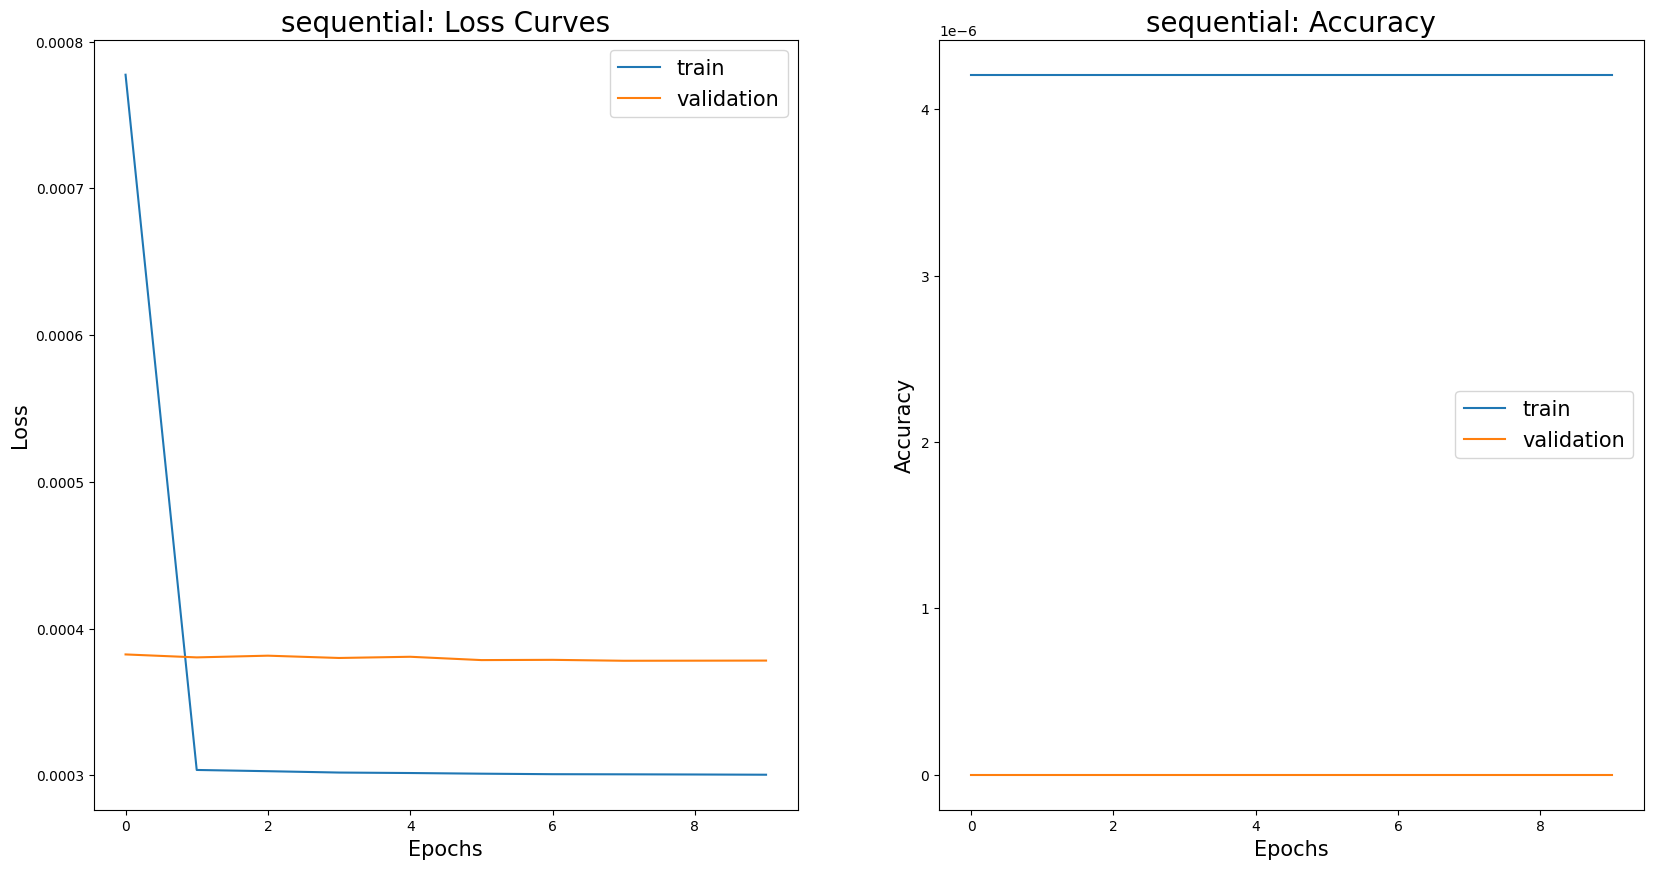

In [51]:
#from src.utils.plotting import summarize_price_model_diagnostics
summarize_price_model_diagnostics(model, history)

In [55]:
ytest_unscaled = yscaler.inverse_transform(ytest.reshape(-1, 1))
mse = mean_squared_error(ytest_unscaled, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(ytest_unscaled, predictions)
r2 = r2_score(ytest_unscaled, predictions)


print(f"Unscaled Mean Squared Error (MSE): {mse}")
print(f"Unscaled Root Mean Squared Error (RMSE): {rmse}")
print(f"Unscaled Mean Absolute Error (MAE): {mae}")
print(f"Unscaled R2 score (r2): {r2}")

Unscaled Mean Squared Error (MSE): 0.0001894854322919466
Unscaled Root Mean Squared Error (RMSE): 0.013765370764783149
Unscaled Mean Absolute Error (MAE): 0.009208365783456905
Unscaled R2 score (r2): -0.0012735227594489196


In [53]:
# Save the price model 
model.save("/kaggle/working/price_model.keras")